In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int, Smooth
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# Use F125W for G141?

In [16]:
### test for 41520

mosaic_f105 = hpath + 'Data/Clear/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits'
mosaic_f125 = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits'
seg_map = hpath + 'Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_seg.fits'
catalog = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat'
flt_path = hpath + '3dhst/s_flt_files/'
instrument = 'G141' # or G141

galaxy_id = 41520 # 3D-HST catalog ID

In [8]:
## Reference catalog
ref_cat = Table.read(catalog,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [10]:
## finds source in flt file, returns if present and the position in pixels

def Source_present(fn,ra,dec):  
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 < pos[0] < xpixlim and 0 < pos[1] < ypixlim and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [13]:
flt_files = glob(flt_path + '*')

grism_flts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        grism_flts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

x=691.3 y=443.8, PA=230.0, file=ibhj11hiq_flt.fits 
x=701.3 y=447.3, PA=230.0, file=ibhj11hpq_flt.fits 
x=697.8 y=453.9, PA=230.0, file=ibhj11hwq_flt.fits 
x=687.7 y=450.3, PA=230.0, file=ibhj11i3q_flt.fits 


In [14]:
orient_1 = flt_path + 'ibhj11hiq_flt.fits' ; PA_1 = 230

In [19]:
## GrismFLT object
flt_f105 = model.GrismFLT(grism_file = orient_1,
                    ref_file = mosaic_f105, 
                    seg_file = seg_map,
                    force_grism = instrument)
  
flt_f125 = model.GrismFLT(grism_file = orient_1,
                    ref_file = mosaic_f125, 
                    seg_file = seg_map,
                    force_grism = instrument)
    
## catalog / semetation image
seg_cat_105 = flt_f105.blot_catalog(ref_cat, sextractor=False)

seg_cat_125 = flt_f125.blot_catalog(ref_cat, sextractor=False)

Image cutout: x=slice(6871, 10860, None), y=slice(14217, 18592, None)
/Users/vestrada/3dhst/s_flt_files/ibhj11hiq_flt.fits / blot reference /Users/vestrada/Data/Clear/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(6871, 10860, None), y=slice(14217, 18592, None)
/Users/vestrada/3dhst/s_flt_files/ibhj11hiq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/3dhst/s_flt_files/ibhj11hiq_flt.fits / blot segmentation /Users/vestrada/Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(6871, 10860, None), y=slice(14217, 18592, None)
/Users/vestrada/3dhst/s_flt_files/ibhj11hiq_flt.fits / blot reference /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=sli

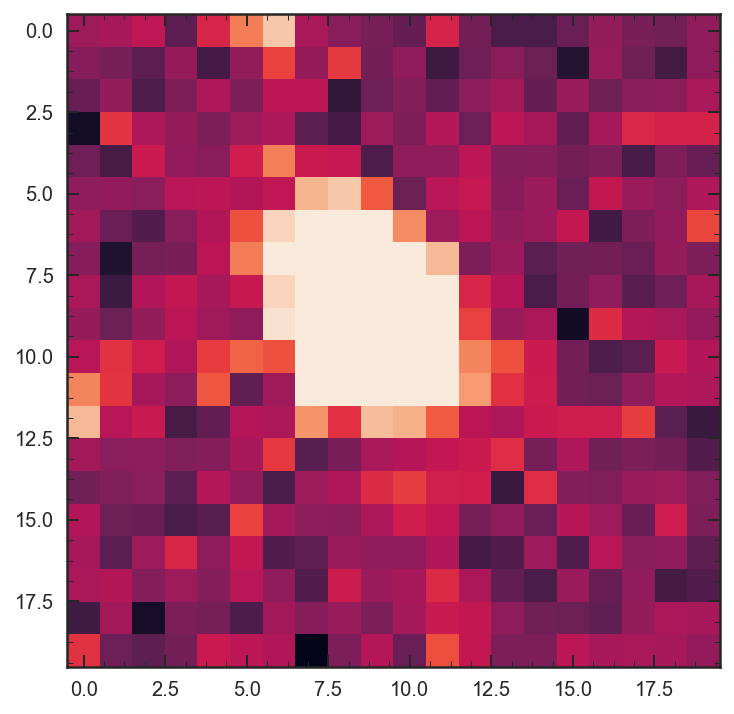

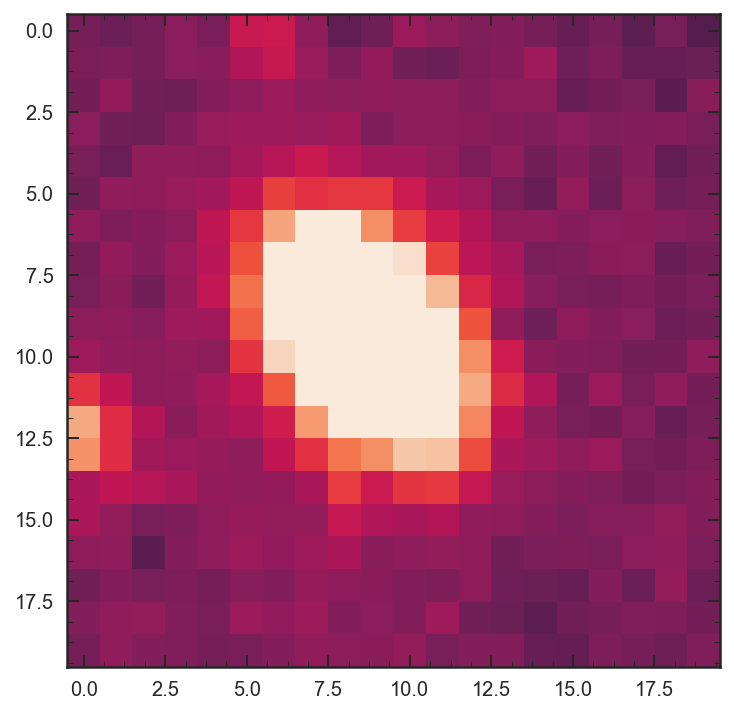

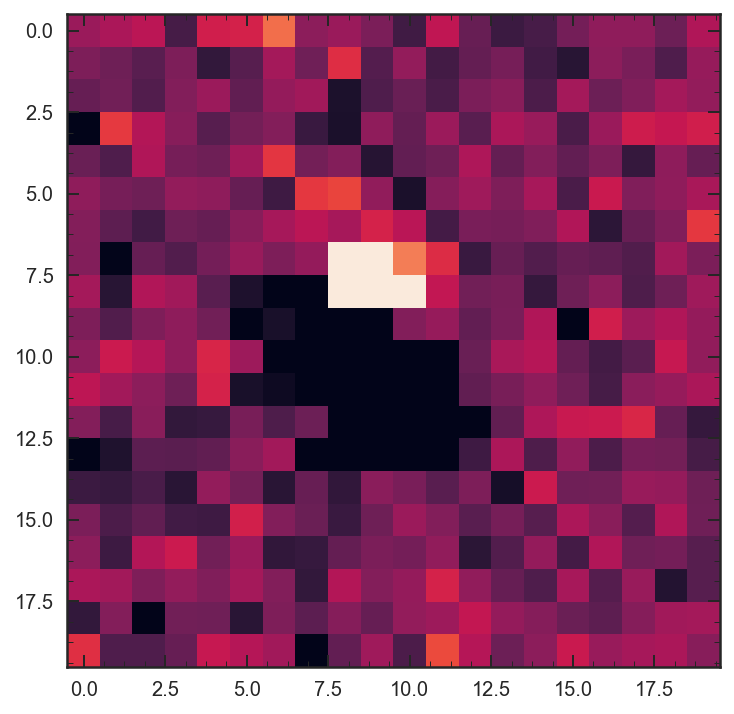

In [23]:
## needed to create the object_disperers dictionary
flt_f105.compute_model_orders(id=galaxy_id)
flt_f125.compute_model_orders(id=galaxy_id)

## Object and spectral order
beam_f105 = flt_f105.object_dispersers[galaxy_id][2]['A']
beam_f125 = flt_f125.object_dispersers[galaxy_id][2]['A']

## BeamCutout object
co_f105 = model.BeamCutout(flt_f105, beam_f105, conf=flt_f105.conf)
co_f125 = model.BeamCutout(flt_f125, beam_f125, conf=flt_f125.conf)

## galaxy cutout from mosiac
plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam_f105.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)

plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam_f125.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)

plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam_f105.direct - beam_f125.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)

# Use Bayes factor evidence to determine best beam for G102 and G141

In [4]:
ls /Users/vestrada/Data/Clear/CATALOGS/goodss_v4.4/



goodss-F105W-astrodrizzle-v4.4_drz_bg.fits
goodss-F105W-astrodrizzle-v4.4_drz_sci.fits
goodss-F105W-astrodrizzle-v4.4_drz_seg.fits
goodss-F105W-astrodrizzle-v4.4_drz_sub.cat
goodss-F105W-astrodrizzle-v4.4_drz_sub.fits
goodss-F105W-astrodrizzle-v4.4_drz_wht.fits
